# TFRecord Parsing & Data Pipeline

In [10]:
# ================================
# 1 Imports & Global Config
# ================================
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input, mixed_precision

# Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Use mixed precision for faster training on GPUs
mixed_precision.set_global_policy('mixed_float16')


# Paths & Dataset Parameters
DATA_PATH = "/home/akokholm/mnt/SUN-BMI-EC-AKOKHOLM/Master-BMI/GitHub_Repository/" \
            "Project_of_Anton_-_Unsupervised_Deep_Learning_of_ECGs_Exploring_the_Latent_Space/" \
            "Data/MIMIC-IV_Subset/subset_*.tfrecord"

EXPECTED_SHAPE = (5000, 12)
BATCH_SIZE = 64
SHUFFLE_BUFFER = 20000


# TFRecord Parsing & Data Pipeline

In [11]:
# ================================
# 2 TFRecord Parsing Function
# ================================
feature_description = {"ecg": tf.io.FixedLenFeature([], tf.string)}

def parse_example(example_proto):
    """Parse a single TFRecord example into (input, target) pair."""
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    ecg = tf.io.decode_raw(parsed["ecg"], out_type=tf.float32)
    ecg = tf.reshape(ecg, EXPECTED_SHAPE)
    return ecg, ecg  # Input = Target for Autoencoder

# ================================
# 3 Dataset Creation
# ================================
def create_dataset(file_pattern=DATA_PATH, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER):
    files = tf.io.gfile.glob(file_pattern)
    files.sort()
    print(f"Found {len(files)} TFRecord files.")

    dataset = tf.data.TFRecordDataset(files, num_parallel_reads=tf.data.AUTOTUNE)
    dataset = dataset.map(parse_example, num_parallel_calls=tf.data.AUTOTUNE)

    # Optimization
    dataset = dataset.cache()  # Keep dataset in RAM if possible
    dataset = dataset.shuffle(buffer_size=shuffle_buffer, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Initialize dataset
train_dataset = create_dataset()


Found 12 TFRecord files.


# Autoencoder Architecture

In [12]:
# ================================
# 4 Autoencoder Model
# ================================
def build_autoencoder(input_shape, latent_dim=64, use_layernorm=False):
    inputs = Input(shape=input_shape)
    
    # --- ENCODER ---
    x = layers.Conv1D(32, 5, strides=2, padding='same', activation='relu')(inputs)
    x = layers.LayerNormalization()(x) if use_layernorm else layers.BatchNormalization()(x)

    x = layers.Conv1D(64, 5, strides=2, padding='same', activation='relu')(x)
    x = layers.LayerNormalization()(x) if use_layernorm else layers.BatchNormalization()(x)

    x = layers.Conv1D(128, 5, strides=2, padding='same', activation='relu')(x)
    x = layers.LayerNormalization()(x) if use_layernorm else layers.BatchNormalization()(x)

    shape_before_flatten = x.shape[1:]
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, name='latent_space')(x)

    # --- DECODER ---
    units = int(np.prod(shape_before_flatten))
    x = layers.Dense(units)(latent)
    x = layers.Reshape(shape_before_flatten)(x)
    x = layers.ReLU()(x)

    x = layers.Conv1DTranspose(128, 5, strides=2, padding='same', activation='relu')(x)
    x = layers.LayerNormalization()(x) if use_layernorm else layers.BatchNormalization()(x)

    x = layers.Conv1DTranspose(64, 5, strides=2, padding='same', activation='relu')(x)
    x = layers.LayerNormalization()(x) if use_layernorm else layers.BatchNormalization()(x)

    x = layers.Conv1DTranspose(32, 5, strides=2, padding='same', activation='relu')(x)
    x = layers.LayerNormalization()(x) if use_layernorm else layers.BatchNormalization()(x)

    outputs = layers.Conv1D(12, 1, padding='same', activation='linear')(x)
    return models.Model(inputs, outputs)

# Build & compile model
latent_dim = 64
autoencoder = build_autoencoder(EXPECTED_SHAPE, latent_dim, use_layernorm=True)
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    jit_compile=True
)

autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5000, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 2500, 32)       │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_12          │ (None, 2500, 32)       │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 1250, 64)       │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_13          │ (None, 1250, 64)       │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 625, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_14          │ (None, 625, 128)       │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 64)             │     5,120,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 80000)          │     5,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 625, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 625, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_6              │ (None, 1250, 128)      │        82,048 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_15          │ (None, 1250, 128)      │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_7              │ (None, 2500, 64)       │        41,024 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_16          │ (None, 2500, 64)       │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_8              │ (None, 5000, 32)       │        10,272 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_17          │ (None, 5000, 32)       │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 5000, 12)       │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,508,044 (40.09 MB)

 Trainable params: 10,508,044 (40.09 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [13]:
# ================================
# 5 Training Setup
# ================================
# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Split validation dataset (~1000 ECGs)
VAL_BATCHES = 16
validation_dataset = train_dataset.take(VAL_BATCHES)
train_dataset_final = train_dataset.skip(VAL_BATCHES)

# Train model
history = autoencoder.fit(
    train_dataset_final,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[early_stopping],
    verbose=2
)


Epoch 1/100


2026-02-13 11:32:48.083524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:47: Filling up shuffle buffer (this may take a while): 4850 of 20000
2026-02-13 11:32:48.523898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2026-02-13 11:32:51.574660: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 19s - 301ms/step - loss: 1.0604 - val_loss: 0.9348
Epoch 2/100


2026-02-13 11:32:56.150277: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:32:56.150330: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 4s - 56ms/step - loss: 0.9766 - val_loss: 0.9322
Epoch 3/100


2026-02-13 11:32:59.628742: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:32:59.628784: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 54ms/step - loss: 0.9760 - val_loss: 0.9334
Epoch 4/100


2026-02-13 11:32:59.938346: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:32:59.938392: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438


63/63 - 3s - 55ms/step - loss: 0.9755 - val_loss: 0.9314
Epoch 5/100


2026-02-13 11:33:03.304434: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:33:03.304481: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438
2026-02-13 11:33:06.512230: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 55ms/step - loss: 0.9684 - val_loss: 0.8979
Epoch 6/100


2026-02-13 11:33:10.005357: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:33:10.005398: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 4s - 60ms/step - loss: 0.8934 - val_loss: 0.7911
Epoch 7/100
63/63 - 3s - 55ms/step - loss: 0.7903 - val_loss: 0.6816
Epoch 8/100


2026-02-13 11:33:17.169633: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:33:17.169682: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 55ms/step - loss: 0.6874 - val_loss: 0.5928
Epoch 9/100


2026-02-13 11:33:17.474152: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:33:17.474193: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438
2026-02-13 11:33:20.670053: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:33:20.670104: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 4s - 56ms/step - loss: 0.6013 - val_loss: 0.5207
Epoch 10/100


2026-02-13 11:33:24.469274: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:33:24.469314: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438


63/63 - 4s - 60ms/step - loss: 0.5355 - val_loss: 0.4607
Epoch 11/100


2026-02-13 11:33:27.911806: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:33:27.911856: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 55ms/step - loss: 0.4834 - val_loss: 0.4186
Epoch 12/100


2026-02-13 11:33:28.252313: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389


63/63 - 4s - 56ms/step - loss: 0.4379 - val_loss: 0.3830
Epoch 13/100
63/63 - 3s - 55ms/step - loss: 0.4016 - val_loss: 0.3485
Epoch 14/100


2026-02-13 11:33:35.237627: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2026-02-13 11:33:38.345905: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:33:38.345983: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 54ms/step - loss: 0.3708 - val_loss: 0.3306
Epoch 15/100


2026-02-13 11:33:38.648099: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:33:38.648138: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438
2026-02-13 11:33:41.818608: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:33:41.818650: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 55ms/step - loss: 0.3453 - val_loss: 0.3113
Epoch 16/100
63/63 - 4s - 59ms/step - loss: 0.3258 - val_loss: 0.2923
Epoch 17/100


2026-02-13 11:33:48.935735: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:33:48.935777: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 55ms/step - loss: 0.3086 - val_loss: 0.2773
Epoch 18/100


2026-02-13 11:33:49.278420: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:33:49.278461: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438


63/63 - 3s - 55ms/step - loss: 0.2919 - val_loss: 0.2619
Epoch 19/100


2026-02-13 11:33:52.746659: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:33:52.746702: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438
2026-02-13 11:33:55.872200: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:33:55.872242: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 55ms/step - loss: 0.2825 - val_loss: 0.2559
Epoch 20/100


2026-02-13 11:33:59.385925: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:33:59.385985: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 55ms/step - loss: 0.2696 - val_loss: 0.2424
Epoch 21/100


2026-02-13 11:34:02.832105: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:34:02.832148: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 55ms/step - loss: 0.2600 - val_loss: 0.2392
Epoch 22/100


2026-02-13 11:34:03.140092: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:34:03.140141: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438
2026-02-13 11:34:06.236834: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:34:06.236879: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 4s - 56ms/step - loss: 0.2560 - val_loss: 0.2332
Epoch 23/100


2026-02-13 11:34:06.628204: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:34:06.628255: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438
2026-02-13 11:34:09.785736: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:34:09.785788: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 53ms/step - loss: 0.2500 - val_loss: 0.2338
Epoch 24/100


2026-02-13 11:34:10.085988: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:34:10.086035: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438
2026-02-13 11:34:13.140857: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:34:13.140899: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 54ms/step - loss: 0.2407 - val_loss: 0.2200
Epoch 25/100


2026-02-13 11:34:13.443193: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:34:13.443235: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438
2026-02-13 11:34:16.580741: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:34:16.580783: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 4s - 58ms/step - loss: 0.2353 - val_loss: 0.2114
Epoch 26/100


2026-02-13 11:34:20.226543: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:34:20.226587: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 4s - 56ms/step - loss: 0.2288 - val_loss: 0.2072
Epoch 27/100


2026-02-13 11:34:20.633716: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:34:20.633764: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438


63/63 - 3s - 55ms/step - loss: 0.2224 - val_loss: 0.2041
Epoch 28/100


2026-02-13 11:34:24.058807: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:34:27.210594: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:34:27.210636: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 55ms/step - loss: 0.2194 - val_loss: 0.2032
Epoch 29/100


2026-02-13 11:34:27.514264: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:34:27.514311: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438
2026-02-13 11:34:30.719341: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:34:30.719385: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 4s - 58ms/step - loss: 0.2120 - val_loss: 0.1924
Epoch 30/100
63/63 - 3s - 55ms/step - loss: 0.2065 - val_loss: 0.1895
Epoch 31/100


2026-02-13 11:34:37.851631: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:34:37.851675: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296
2026-02-13 11:34:38.164322: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:34:38.164370: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438


63/63 - 4s - 59ms/step - loss: 0.2022 - val_loss: 0.1858
Epoch 32/100


2026-02-13 11:34:41.508845: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:34:41.508887: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 54ms/step - loss: 0.1965 - val_loss: 0.1813
Epoch 33/100
63/63 - 3s - 55ms/step - loss: 0.1933 - val_loss: 0.1739
Epoch 34/100


2026-02-13 11:34:45.245121: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:34:45.245167: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438
2026-02-13 11:34:48.385786: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:34:48.385828: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 53ms/step - loss: 0.1895 - val_loss: 0.1767
Epoch 35/100


2026-02-13 11:34:48.685733: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:34:48.685773: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438
2026-02-13 11:34:51.813219: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 55ms/step - loss: 0.1839 - val_loss: 0.1648
Epoch 36/100


2026-02-13 11:34:52.122213: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:34:52.122253: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438
2026-02-13 11:34:55.321489: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:34:55.321531: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296
2026-02-13 11:34:55.634151: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:34:55.634192: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438


63/63 - 4s - 58ms/step - loss: 0.1806 - val_loss: 0.1622
Epoch 37/100


2026-02-13 11:34:58.911254: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:34:58.911308: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 55ms/step - loss: 0.1772 - val_loss: 0.1665
Epoch 38/100


2026-02-13 11:35:02.413255: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 55ms/step - loss: 0.1746 - val_loss: 0.1585
Epoch 39/100


2026-02-13 11:35:05.809966: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:35:05.810011: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 53ms/step - loss: 0.1694 - val_loss: 0.1593
Epoch 40/100
63/63 - 3s - 55ms/step - loss: 0.1673 - val_loss: 0.1559
Epoch 41/100
63/63 - 3s - 54ms/step - loss: 0.1642 - val_loss: 0.1490
Epoch 42/100


2026-02-13 11:35:12.959497: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:35:12.959538: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438


63/63 - 3s - 54ms/step - loss: 0.1615 - val_loss: 0.1509
Epoch 43/100


2026-02-13 11:35:19.419537: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:35:19.419587: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 53ms/step - loss: 0.1592 - val_loss: 0.1511
Epoch 44/100


2026-02-13 11:35:19.723032: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:35:19.723073: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438


63/63 - 3s - 54ms/step - loss: 0.1572 - val_loss: 0.1428
Epoch 45/100


2026-02-13 11:35:26.258890: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:35:26.258931: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 54ms/step - loss: 0.1558 - val_loss: 0.1450
Epoch 46/100


2026-02-13 11:35:29.670332: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:35:29.670375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 54ms/step - loss: 0.1537 - val_loss: 0.1380
Epoch 47/100


2026-02-13 11:35:33.103273: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:35:33.103314: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 55ms/step - loss: 0.1511 - val_loss: 0.1358
Epoch 48/100


2026-02-13 11:35:33.417792: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:35:33.417835: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438
2026-02-13 11:35:36.524492: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:35:36.524543: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 54ms/step - loss: 0.1511 - val_loss: 0.1411
Epoch 49/100
63/63 - 3s - 54ms/step - loss: 0.1486 - val_loss: 0.1395
Epoch 50/100


2026-02-13 11:35:40.236889: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:35:40.236957: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438
2026-02-13 11:35:43.396929: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16421187370767683261
2026-02-13 11:35:43.397007: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 55ms/step - loss: 0.1465 - val_loss: 0.1393
Epoch 51/100


2026-02-13 11:35:46.844513: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 54ms/step - loss: 0.1448 - val_loss: 0.1379
Epoch 52/100


2026-02-13 11:35:47.141359: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:35:47.141399: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438
2026-02-13 11:35:50.331126: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5646273511057614296


63/63 - 3s - 55ms/step - loss: 0.1432 - val_loss: 0.1373


2026-02-13 11:35:50.636892: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16042975164781837389
2026-02-13 11:35:50.636978: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9128782861523744438


# Visualizations

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 


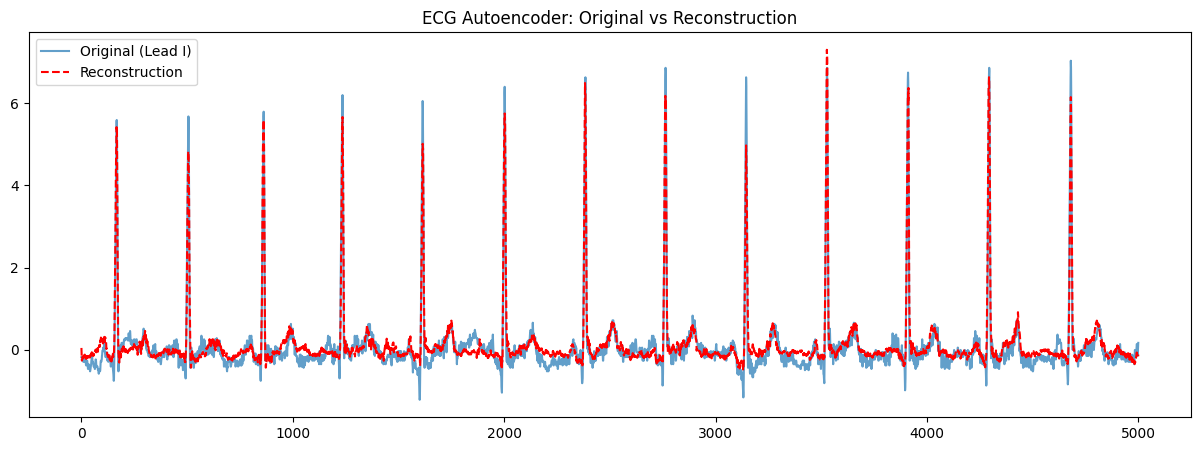

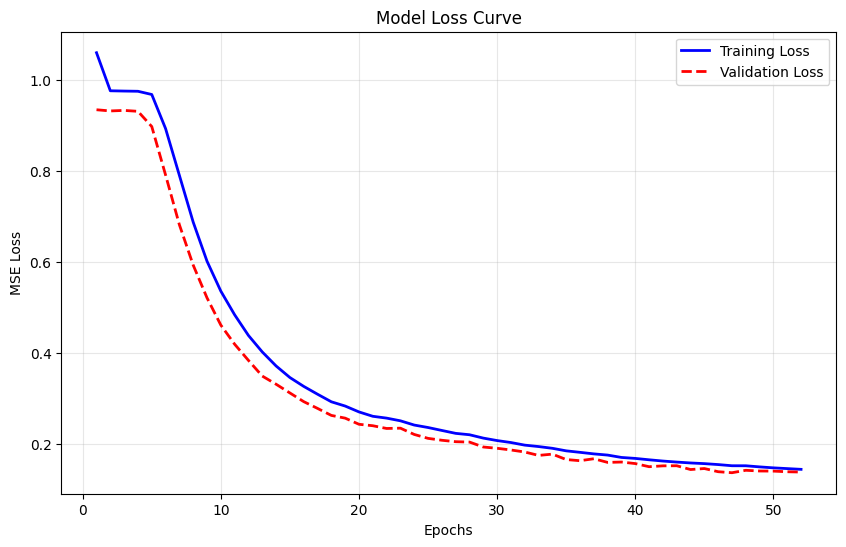

In [14]:
# ================================
# 6 Plot Reconstruction of a Single ECG
# ================================
def plot_reconstruction(dataset, model):
    for x_batch, _ in dataset.take(1):
        reconstructed = model.predict(x_batch)
        plt.figure(figsize=(15, 5))
        plt.plot(x_batch[0, :, 0], label="Original (Lead I)", alpha=0.7)
        plt.plot(reconstructed[0, :, 0], label="Reconstruction", color='red', linestyle='--')
        plt.title("ECG Autoencoder: Original vs Reconstruction")
        plt.legend()
        plt.show()
        break

plot_reconstruction(train_dataset, autoencoder)

# ================================
# 7 Training Loss Curve
# ================================
def plot_training_history(history):
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, 'b-', label='Training Loss', linewidth=2)
    
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'r--', label='Validation Loss', linewidth=2)
    
    plt.title('Model Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_training_history(history)
